# Introduction
In this project, I will create a table with information about metropolitan areas in the United States. For simplicity, they will just be called "cities". The variables are:
- Population,
- Average Rental Price,
- Median Rental Price,
- Unemployment Rate,
- Per Capita Income,
- Air Quality,
- Walk, Transit, and Bike Scores, 
- Cost of Living,
- Price Parity,
- Median Commute Time,
- Latitude, Longitude.

<b>Part I.</b>
After finding the data in open sources, I clean it if necessary and load it one by one with a simple custom function. Along the way, I explain the methodology for each metric and what it means. The data set can be found on this project's [GitHub page](https://github.com/denislsad/us_cities) and on [Kaggle](https://www.kaggle.com/datasets/denissad/us-cities).

<b> Part II.</b>The second part of the project is exploratory data analysis. I explore the variables I find most interesting and their relationship to each other through visualization and testing.
    
<b>Expectations.</b> A complete dataset with American cities and information about them. A demonstration of what can be done with this data for analysis and insights.

# Loading Data
In this part we will create a DataFrame with the 14 columns mentioned above, explaining the meaning and methodology behind each one.

In [26]:
# Import libraries used in this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import scikit_posthocs as sp

Create an empty DataFrame and define a function to append new columns to it later.

In [27]:
cities = pd.DataFrame(columns=['City', 'State'])

def merge_frames(new_df, method='left', print_ten=False):
    df = pd.merge(cities, new_df, on=['City', 'State'], how=method)
    if print_ten == True:
        print(df.head(10))
    return df

##### First four columns

### Population
Metropolitan Area Population in 2020. Data from Census, retrieved from [citypopulation.de](https://citypopulation.de/) and preprocessed by myself in Excel.

In [28]:
pop = pd.read_csv('Data/population.csv')
cities = merge_frames(pop, method='right', print_ten=True)

           City State  Population
0      New York    NY  20140470.0
1   Los Angeles    CA  13200998.0
2       Chicago    IL   9618502.0
3        Dallas    TX   7637387.0
4       Houston    TX   7122240.0
5    Washington    DC   6385162.0
6  Philadelphia    PA   6245051.0
7         Miami    FL   6138333.0
8       Atlanta    GA   6089815.0
9        Boston    MA   4941632.0


### Average Rent
The average rent for a one-bedroom apartment. Data from [Zillow](https://www.zillow.com/research/data/).\
Monthly averages are calculated by regressing changes in rental prices on the change in time between two transactions and adjusting the weights based on the prevalence of rented units. The index is then smoothed and denominated in dollars to make it easier to interpret.

In [29]:
# Load data with rent means, assign columns names
cols = ['RegionName', 'StateName', '2023-01-31']
new_cols = ['City', 'State', 'AvgRent']
rent_means = pd.read_csv('Data/rent_mean_2023.csv', usecols=cols)
rent_means.columns = new_cols

In [30]:
# Drop NaN values, change data types
rent_means = rent_means.dropna(how='any')
rent_means['City'] = rent_means['City']
rent_means.loc[:, 'AvgRent'] = rent_means['AvgRent'].apply(lambda x: int(x))

In [31]:
# Append the average rent variable to the main DataFrame with a custom function
cities = merge_frames(rent_means, method='inner', print_ten=True)

           City State  Population  AvgRent
0      New York    NY  20140470.0     3272
1   Los Angeles    CA  13200998.0     2857
2       Chicago    IL   9618502.0     1975
3        Dallas    TX   7637387.0     1754
4       Houston    TX   7122240.0     1620
5    Washington    DC   6385162.0     2421
6  Philadelphia    PA   6245051.0     1663
7         Miami    FL   6138333.0     3201
8       Atlanta    GA   6089815.0     1991
9        Boston    MA   4941632.0     3419


### Median Rent
Median prices for a one-bedroom apartment. Data from [HUD User](https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation).\
The 50th percentile rent estimates are based on the most recent data available from the [American Community Survey](https://www.census.gov/data/developers/data-sets/acs-5year.html), which is conducted by the U.S. Census Bureau. They are calculated using a model that takes into account geography, unit size, and lease type (e.g., rent-controlled vs. market rate).

In [32]:
# Load data with rent means, assign column names, set delimiters
cols = ['hud_areaname', 'rent_50_1']
new_cols = ['City', 'MedianRent']
rent_medians = pd.read_csv('Data/rent_median_2023.tsv', usecols=cols, delimiter='\t')
rent_medians.columns = new_cols

In [33]:
# Create a State column and clean up the city names
rent_medians['State'] = rent_medians['City'].apply(lambda x: x.split(',')[-1].strip()[:2])
rent_medians['City'] = rent_medians['City'].apply(lambda x: x.split(',')[0].split('-')[0])

# Remove the comma from MedianRent and make it an integer
def remove_comma(x):
    if ',' in x:
        return x.replace(',', '')
    return x
rent_medians['MedianRent'] = rent_medians['MedianRent'].apply(lambda x: int(remove_comma(x)))

rent_medians.head(10)

,City,MedianRent,State
0,San Francisco,3000,CA
1,San Jose,2763,CA
2,Santa Cruz,2602,CA
3,Santa Maria,2490,CA
4,Boston,2368,MA
5,Salinas,2324,CA
6,New York,2323,NY
7,Stamford,2321,CT
8,Santa Ana,2274,CA
9,Dukes County,2200,MA


In [34]:
cities = merge_frames(rent_medians, print_ten=True)

           City State  Population  AvgRent  MedianRent
0      New York    NY  20140470.0     3272      2323.0
1   Los Angeles    CA  13200998.0     2857      1925.0
2       Chicago    IL   9618502.0     1975      1364.0
3        Dallas    TX   7637387.0     1754      1440.0
4       Houston    TX   7122240.0     1620      1216.0
5    Washington    DC   6385162.0     2421      1740.0
6  Philadelphia    PA   6245051.0     1663      1314.0
7         Miami    FL   6138333.0     3201      1670.0
8       Atlanta    GA   6089815.0     1991      1489.0
9        Boston    MA   4941632.0     3419      2368.0


### Unemployment
Unemployment Rates for Metropolitan Areas in January 2023, Not Seasonally Adjusted. Data from [U.S. Bureau of Labor Statistics](https://www.bls.gov/web/metro/laummtrk.htm#laummtrk.f.p).\
The unemployment rate is calculated as the number of unemployed individuals divided by the total labor force, which is the sum of employed and unemployed individuals. The unemployed are defined as individuals who are not currently employed but are available for work and have actively sought work in the past four weeks. Data are collected through a monthly survey of households called the Current Population Survey. The survey is conducted by the U.S. Census Bureau and is designed to be representative of the civilian, noninstitutionalized population 16 years of age and older.

In [35]:
# The data in unemp.txt needs some cleaning, 
# because the values are separated by not one, but three delimiters (tabs, commas, and newlines).
temp_list1 = []
temp_list2 = []
unemp_list = []

# Open text file with unemployment rate data. 
# This file is broken, because every first value has a newspace character and every second has a trailing tab.
with open("Data/unemp.txt", 'r') as unemp:
    for i, line in enumerate(unemp.readlines()):
        # If line is even, add to the first temp_list
        if i % 2 == 0:
            # Clean the line and split cities and states
            this_line = line.rstrip(' \n').split(', ')
            # Leave only one city from metropolitan area and one state
            city_state = [this_line[j].split('-')[0] for j in range(len(this_line))]            
            temp_list1.append(city_state)
        # If line is odd, add to the second temp_list
        else:
            # We need onnly the rate variable
            temp_list2.append(line.split('\t')[0])

# Create a final list from two temporary ones
for i in range(len(temp_list1)):
    unemp_list.append(temp_list1[i] + [temp_list2[i]])
del temp_list1, temp_list2

In [36]:
# Create an unemployment DF
unemp_df = pd.DataFrame(unemp_list, columns=['City', 'State', 'UnempRate'])
print(unemp_df.head(10))

          City State UnempRate
0      Madison    WI       1.6
1     Columbia    MO       1.7
2      Decatur    AL       1.8
3  Fond du Lac    WI       1.8
4   Huntsville    AL       1.8
5        Logan    UT       1.8
6    Sheboygan    WI       1.8
7         Ames    IA       1.9
8     Appleton    WI       1.9
9     Columbus    IN       1.9


In [37]:
cities = merge_frames(unemp_df)

#### Last ten columns
The next set of variables come in a more tidy format and are simply appended to the main DataFrame. However, some of them were pre-processed by me in Excel to save time. In most cases, it was just a matter of splitting the columns by a certain delimiter and deleting unnecessary commas and dots in the numeric values.


### Average Income
Per Capita Income by Metropolitan Area in 2021.Data from [U.S. Bureau of Economic Analyses](https://www.bea.gov/data/income-saving/personal-income-county-metro-and-other-areas) (pre-processed by myself in Excel).\
Per capita income is calculated by dividing population by personal income. Total personal income includes all income received by all people in the area, including wages and salaries, proprietors' income, rental income, and government transfer payments. Population estimates are based closely on data from the U.S. Census Bureau.

In [38]:
income_personal = pd.read_csv('Data/income_personal.csv')
cities = merge_frames(income_personal)

### Air Quality
Air Quality Index (AQI). Data from [U.S. Environmental Protection Agency](aqs.epa.gov).\
The AQI is based on concentrations of five major air pollutants regulated by the Clean Air Act: ground-level ozone, particulate matter, carbon monoxide, sulfur dioxide, and nitrogen dioxide.
The AQI is calculated based on the highest concentration of these pollutants in a given area over a given period of time and then scaled to a value between 0 and 500.\
An AQI less than 50 is considered good, from 51 to 100 - moderate. If the AQI is higher than 100, the air quality is unhealthy: first for certain sensitive groups of people, and then for everyone as the AQI gets higher and higher.

In [39]:
air = pd.read_csv('Data/aqi.csv')
cities = merge_frames(air)

### Walkability and Bike Score
Data from [Walk Score](https://www.walkscore.com/).

Walk Score measures the walkability of an area. Points are assigned to each address based on the distance to amenities in each category. Amenities within a 5-minute walk receive maximum points. A decay function is used to award points to more distant amenities, with no points awarded after a 30-minute walk.

Bike Score measures how good a place is for biking. It's calculated by measuring bike infrastructure (lanes, trails, etc.), hills, destinations and street connectivity, and the number of bike commuters.

Each score uses the same metric to translate itself into a description. Example with Walk Score:
- 90–100	Daily errands do not require a car (Walker's Paradise)
- 70–89	    Most errands can be accomplished on foot.
- 50–69	    Some errands can be accomplished on foot.
- 25–49	    Most errands require a car (car-dependent).
- 0–24	    Almost all errands require a car (car-dependent).

In [40]:
walkability = pd.read_csv('Data/walkscore.csv')
cities = merge_frames(walkability)

### Transit Score
Data from [AllTransit](https://alltransit.cnt.org/rankings/).

Transit Score measures access to public transportation. The Performance Score by AllTransit takes into account connections to other lines, jobs within a 30-minute transit commute, and the number of workers who use transit to get to work. It measures the performance on a scale of 0 to 10.


In [41]:
transit_score = pd.read_csv('Data/transit_score.csv')
cities = merge_frames(transit_score, print_ten=True)

           City State  Population  AvgRent  MedianRent UnempRate  AvgIncome  \
0      New York    NY  20140470.0     3272      2323.0       3.8    85136.0   
1   Los Angeles    CA  13200998.0     2857      1925.0       3.9    75821.0   
2       Chicago    IL   9618502.0     1975      1364.0       4.2    71992.0   
3        Dallas    TX   7637387.0     1754      1440.0       3.2    66727.0   
4       Houston    TX   7122240.0     1620      1216.0       3.9    64837.0   
5    Washington    DC   6385162.0     2421      1740.0       2.8    80822.0   
6  Philadelphia    PA   6245051.0     1663      1314.0       3.4    72379.0   
7         Miami    FL   6138333.0     3201      1670.0       1.9    73522.0   
8       Atlanta    GA   6089815.0     1991      1489.0       2.6    63219.0   
9        Boston    MA   4941632.0     3419      2368.0       2.9    92290.0   

   MedianAQI  WalkScore  BikeScore  TransitScore  
0       50.0       88.0       69.3           6.9  
1       70.0       68.6     

### Cost of Living Index and Price Parities
Data from [AdvisorSmith](https://advisorsmith.com/data/coli/compare/abilene-tx-vs-new-york-ny/) and [Bureau of Economic Analysis](https://apps.bea.gov/)(BEA).

The cost of living was determined based on six major expense categories: food, housing, utilities, transportation, health care, and discretionary spending. The index is constructed to normalize the average cost of living in the United States to 100. The percentage weight assigned to each category was determined based on the average U.S. household budget, based on the Consumer Expenditure Surveys  (not to confuse with Current Population Survey used for unemployment rate).

A Regional Price Parity (RPP) is a weighted average of the price level of goods and services for the average consumer in a geographic region compared to all other regions in the United States. The RPP for all regions is 100 (e.g., a price parity of 114.58 in New York means that prices in New York are, on average, 14.58% higher than the U.S. average). First, the BEA collects and organizes price data. Then it compares prices across regions (this is done by calculating relative price levels for each region, using the national average price level as a benchmark). Finally, it calculates the RPP by using the relative price levels to adjust for differences in the cost of living across regions.

In [42]:
cost_of_living = pd.read_csv('Data/cost_of_living_index.csv')
rpp = pd.read_csv('Data/price_parities.csv')

In [43]:
cities = merge_frames(cost_of_living)
cities = merge_frames(rpp)

### Median Travel Time to Work
Data from U.S. Census, preprocessed by me in Excel.\
Commute time is collected by the American Community Survey (ACS – the same one that was used to collect median rents). The ACS asks respondents to report the total number of minutes it usually takes them to get from home to work. The median is then calculated based on the responses of all workers in a metropolitan area. More about the methodology [here](https://www.census.gov/programs-surveys/acs/methodology/design-and-methodology.html).

##### Getting the data
I had problems downloading the file from the Census website, so I manually copied and pasted the values into Excel. But it was all pasted in one column – with commute values in every other row. To fix this, I:
1. Moved the time values to another column with `=IF(ISEVEN(ROW(A1)),A1,"")`,
![Even Rows](Media/commute1.png)
2. Moved the metro values to the third column with `=IF(ISODD(ROW(A1)),A1,"")`,
3. Replaced these formulas with values and deleted the original broken column,
![Two Columns](Media/commute2.png)
4. Moved column A up by one cell,
5. Filtered out the empty cells,
6. Dropped duplicates,
7. Split the geographic colummn by City and State,
8. Removed the second and third towns in metropolitan area names.

In [44]:
commute = pd.read_csv('Data/commute.csv')
cities = merge_frames(commute)

### Location
Latitude and longitude for mapping data with Plotly and Tableau. Data from [SimpleMaps](https://simplemaps.com/data/us-cities).

In [45]:
geodata = pd.read_excel('Data/geodata.xlsx')
cities = merge_frames(geodata)

### Categorical Variables and State Names
Lastly, we need to add two categorical variables for the future analysis, namely:
- Region – for this I'll use the Census division of South, Midwest, Northeast, West;
- Size rank – whether a city is considered large, small, or in between.
Also, I want to change the two-letter state abbreviations to full names, because it looks nicer.


First, I ask ChatGPT to generate two dictionaries. One with two-letter state names as keys and full names as values and one with regions as keys and full names as values.\
Then I'll modify the DataFrame using these dictionaries.

<b>The Region Category</b>

In [46]:
# Import generated dictionaries
from state_dicts import state_names, us_regions

# Create a new list by matching values from the State column with state_names dictionary
state_list = list(cities.State)
new_state_list = [state_names[state_list[i]] for i in range(len(state_list))]
# Change values in the State column
cities['State'] = new_state_list

# Create a new column with region information by iterating through us_region dictionary and the State column, and matching the values
region_list = [next(key for key, val in us_regions.items() if x in val) for x in cities['State']]
cities['Region'] = region_list

<b>The Size Category</b><br>
There is no single definition of what constitutes a large, medium, or small metropolitan area. The definition varies depending on the context. Given the data, for the purposes of this project, the size of a metropolitan area is defined as follows:
- Large — over one million people,
- Mid-sized — over 250 thousand and less than one million people,
- Small — less than 250 thousand people.

In [47]:
cities['Size'] = pd.cut(cities['Population'], bins=[0, 250000, 1000000, np.inf], labels=['Small', 'Mid-Sized', 'Large'])

In [48]:
# Rearrange the columns
cols = list(cities.columns) 
cities = cities[cols[:2] + cols[-2:] + cols[2:7] + cols[11:14] + cols[7:11] + cols[14:16]]

In [49]:
# Final version of the DataFrame before cleaning
cities.sample(5)

,City,State,Region,Size,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore,Latitude,Longitude
225,Redding,California,West,Small,182155.0,1445,1081.0,4.1,54972.0,108.7,99.40,NaN,44.0,NaN,NaN,1.8,40.5698,-122.3650
249,Blacksburg,Virginia,South,Small,166378.0,1926,924.0,2.5,44904.0,94.5,92.19,20.5,40.0,NaN,NaN,2.0,37.2300,-80.4279
140,Tallahassee,Florida,South,Mid-Sized,384298.0,1360,1086.0,2.2,52279.0,96.4,94.97,22.6,43.0,NaN,NaN,2.6,30.4551,-84.2527
263,Traverse City,Michigan,Midwest,Small,153448.0,1592,NaN,NaN,NaN,99.6,NaN,22.5,39.0,NaN,NaN,NaN,44.7546,-85.6038
365,Casper,Wyoming,West,Small,79955.0,1122,787.0,3.9,70175.0,94.2,91.34,NaN,43.0,NaN,NaN,1.8,42.8420,-106.3208


# Cleaning Data

### Checking for null values
First, we find the non-standard missing values – the ones that are undetectable by pandas because they don't look like NaN.\
To do this, we loop through the rows of numeric columns and try to convert values to int. If that's not possible, then there's missing data.

In [50]:
# Select only numeric columns
cols_to_loop = cities.columns[4:]

# Dictionary to store all non-standard missing values and their amounts
missing_dict = dict()

# Loop though each row
for i, row in cities.iterrows():
    # And then though each column
    for col in cols_to_loop:
        # Try convert values of the original DF to integers
        try:
            cities.at[i, col] = float(cities.at[i, col])

        # If that's not possible then it's missing data
        except ValueError:
            # If new string encountered, add to dictionary, otherwise update count
            if row[col] in missing_dict:
                missing_dict[row[col]] += 1
            else:
                missing_dict[row[col]] = 1

            # Replace this string with NaN
            cities.at[i, col] = np.nan

missing_dict

{}

### Drop Rows with Lots of NaN Values
Our table has too many missing values for the simple reason that each CSV we loaded had a different set of cities. There are 67 cities out of 456 with all the rows filled.

In [51]:
# Number of cities with all the rows filled
cities.loc[cities.isna().sum(axis=1) == 0, 'City'].count()

73

We'll delete cities with more than half of the variables missing. They are all quite small, with only a dozen metro areas having more than 100,000 inhabitants.

In [52]:
dropped_cities = (cities.isna().sum(axis=1) >= 6)
cities = cities.loc[~dropped_cities].reset_index(drop=True)

### Check If All the Data Types Are Correct

In [53]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   City          344 non-null    object  
 1   State         344 non-null    object  
 2   Region        344 non-null    object  
 3   Size          344 non-null    category
 4   Population    344 non-null    float64 
 5   AvgRent       344 non-null    int64   
 6   MedianRent    338 non-null    float64 
 7   UnempRate     335 non-null    object  
 8   AvgIncome     344 non-null    float64 
 9   CostOfLiving  335 non-null    float64 
 10  PriceParity   343 non-null    float64 
 11  CommuteTime   289 non-null    float64 
 12  MedianAQI     302 non-null    float64 
 13  WalkScore     74 non-null     float64 
 14  BikeScore     74 non-null     float64 
 15  TransitScore  344 non-null    float64 
 16  Latitude      344 non-null    float64 
 17  Longitude     344 non-null    float64 
dtypes: categor

Unemployment Rate and Transit Score are seen as objects by pandas, although they should be floating po

In [54]:
cities['UnempRate'] = cities['UnempRate'].astype(float)
cities['TransitScore'] = cities['TransitScore'].astype(float)

### Final Version of the Table

In [55]:
cities.sample(10)

,City,State,Region,Size,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore,Latitude,Longitude
9,Boston,Massachusetts,Northeast,Large,4941632.0,3419,2368.0,2.9,92290.0,132.6,109.69,31.2,44.0,82.8,69.4,5.0,42.3188,-71.0852
23,San Antonio,Texas,South,Large,2558143.0,1441,1138.0,3.3,53648.0,92.7,96.38,26.7,51.0,36.9,44.5,4.5,29.4632,-98.5238
74,Stockton,California,West,Mid-Sized,779233.0,1915,1257.0,5.2,57783.0,113.6,104.61,33.3,43.0,43.7,52.4,3.0,37.9765,-121.3109
296,Cleveland,Tennessee,South,Small,126164.0,1328,754.0,3.1,45404.0,89.5,88.02,NaN,NaN,NaN,NaN,0.0,35.1817,-84.8707
130,Savannah,Georgia,South,Mid-Sized,404798.0,1744,1204.0,2.5,53570.0,97.3,95.42,24.3,39.0,NaN,NaN,2.5,32.0286,-81.1821
79,Lakeland,Florida,South,Mid-Sized,725046.0,1674,1010.0,2.7,43556.0,96.4,96.17,25.7,41.0,NaN,NaN,1.6,28.0557,-81.9545
199,Lake Charles,Louisiana,South,Small,222402.0,1083,833.0,3.0,51080.0,89.4,90.24,NaN,44.0,NaN,NaN,0.9,30.2010,-93.2111
53,Urban Honolulu,Hawaii,West,Large,1016508.0,2428,1892.0,3.4,63912.0,NaN,114.74,29.0,29.0,65.7,51.0,6.4,21.3294,-157.8460
62,Albany,New York,Northeast,Mid-Sized,899262.0,1475,1166.0,2.5,67788.0,100.1,99.16,23.4,39.0,NaN,NaN,3.6,42.6664,-73.7987
75,Greensboro,North Carolina,South,Mid-Sized,776566.0,1421,981.0,3.6,51872.0,91.0,92.82,22.1,43.0,29.4,32.2,1.8,36.0956,-79.8271


Create an Excel and CSV documents from our final DataFrame.

In [56]:
cities.to_excel('us_cities.xlsx')
cities.to_csv('us_cities.csv')

# Exploring Data
Now we have all variables of the same data type and all rows with at least half of the values not missing. For the rest of this project, I will cover only a fraction of what can be done, as the possibilities for visualizing this data are endless. I will focus on some of the variables that I found most interesting.

### Map
Display our final data on the map with Plotly Express.

In [57]:
fig = px.scatter_geo(cities,
                    lat='Latitude',
                    lon='Longitude',
                    size='Population',
                    color='Size',
                    hover_data=cities.columns[:13],
                    size_max=30,
                    width=1000,
                    height=600)


fig.update_layout(
    title_text = 'US Cities',
    geo_scope='usa',
)
fig.show()

### All Variables Heat Map
First, look at the correlation between all variables in the data set with a heat map.

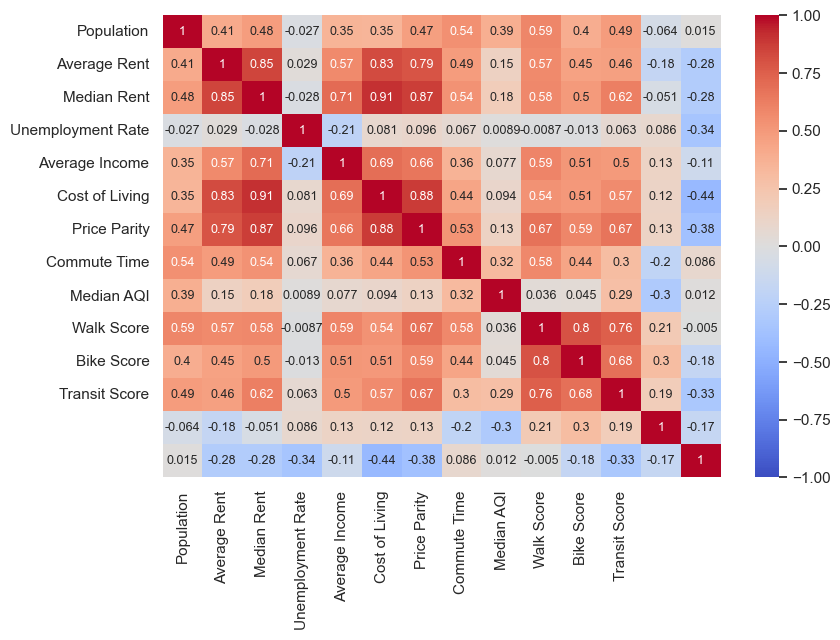

In [58]:
# Full names of variables for better readability
columns_full_names = ['Population', 'Average Rent', 'Median Rent', 'Unemployment Rate', 'Average Income', 
                      'Cost of Living', 'Price Parity', 'Commute Time', 'Median AQI', 'Walk Score', 'Bike Score', 'Transit Score']

# Set theme for all the future graphs
sns.set_theme(style="white", rc={'figure.figsize':(9,6)})

sns.heatmap(cities.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1, annot_kws={"size": 9}, xticklabels=columns_full_names, yticklabels=columns_full_names)
plt.show()

From this map, we can see that:

* There are a number of fairly obvious observations. High cost of living is accompanied by high rental prices and high incomes (and vice versa). It makes sense since rental prices contribute a lot to cost of living. Also, cities with good walkability are good at public transportation and bike construction.
* Another obvious observation is that cities with large populations are, on average, more expensive, have higher incomes, and have worse air quality.
* A correlation between air quality (<i>note that this is the only metric where the higher means the worse</i>) and commute time can indicate either that air quality is affected by traffic congestion and transportation emissions, or that both parameters are caused by high population.
* The unemployment rate has a near-zero correlation with all other variables. However, the only significant correlation is with average income, meaning that higher unemployment rates tend to be associated with lower average incomes.
* The median rent has a stronger correlation with other factors than the average rent, meaning it could be a more important factor in determining a city's livability.

### Summary Statistics by Size

Use the df.describe() method to get summary statistics about the DataFrame. But to better understand the situation, it's better to divide our table into three by metropolitan area size.

In [59]:
# Summary statistics for large cities
large_cities = cities.loc[cities.Size == 'Large']
large_cities.describe()

,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore,Latitude,Longitude
count,5.600000e+01,56.000000,56.000000,55.000000,56.00000,55.000000,56.000000,56.000000,56.000000,51.000000,51.000000,56.000000,56.000000,56.000000
mean,3.377466e+06,1833.964286,1376.803571,3.040000,67278.37500,105.452727,100.760893,26.883929,48.321429,52.929412,54.570588,3.801786,36.992770,-93.794825
std,3.296962e+06,608.939554,467.829472,0.783771,15070.67341,18.644450,7.328437,3.494764,9.309052,16.642335,12.757355,1.514475,5.281255,18.151173
min,1.008654e+06,1130.000000,830.000000,1.900000,50384.00000,86.700000,90.620000,21.200000,29.000000,25.600000,30.700000,0.100000,21.329400,-157.846000
25%,1.394931e+06,1382.000000,1020.500000,2.550000,58955.25000,93.450000,95.435000,24.475000,44.000000,41.150000,43.900000,2.600000,33.715150,-106.376525
50%,2.274416e+06,1717.000000,1287.500000,2.900000,64239.00000,100.100000,98.850000,26.450000,46.000000,49.500000,54.000000,3.600000,37.642650,-87.241850
75%,4.112082e+06,1979.000000,1533.750000,3.400000,70710.50000,108.550000,105.382500,29.000000,51.000000,65.700000,64.850000,5.025000,40.715125,-80.675250
max,2.014047e+07,3422.000000,3000.000000,6.200000,136338.00000,178.600000,119.830000,36.700000,84.000000,88.700000,83.500000,6.900000,47.621100,-71.085200


In [60]:
# Summary statistics for mid-sized cities
mid_cities = cities.loc[cities.Size == 'Mid-Sized']
mid_cities.describe()

,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore,Latitude,Longitude
count,129.000000,129.000000,129.000000,125.000000,129.000000,122.000000,129.000000,126.000000,129.000000,23.000000,23.000000,129.000000,129.000000,129.000000
mean,503160.472868,1521.248062,1068.031008,3.446400,57256.813953,97.607377,95.566589,23.334921,41.193798,38.365217,45.047826,2.334884,37.386640,-92.338268
std,206013.220412,479.419620,342.103236,1.329294,12252.266043,13.052837,5.534128,2.894141,6.788176,7.553904,8.968828,1.124490,5.666978,16.017321
min,256728.000000,781.000000,663.000000,1.600000,34503.000000,83.900000,85.880000,17.300000,18.000000,21.400000,29.700000,0.400000,25.997500,-149.109100
25%,328883.000000,1217.000000,854.000000,2.500000,50616.000000,88.625000,91.870000,21.425000,39.000000,33.250000,40.300000,1.500000,33.364500,-98.246700
50%,433353.000000,1420.000000,959.000000,3.100000,54623.000000,93.250000,93.960000,22.900000,42.000000,39.100000,43.700000,2.100000,37.689500,-87.191100
75%,649903.000000,1784.000000,1188.000000,3.900000,61547.000000,102.075000,98.960000,24.800000,44.000000,43.900000,51.900000,3.000000,41.311300,-81.322300
max,978529.000000,3350.000000,2602.000000,8.800000,127391.000000,163.900000,111.810000,33.300000,67.000000,49.700000,65.500000,5.100000,61.150800,-70.271500


In [61]:
# Summary statistics for small cities
small_cities = cities.loc[cities.Size == 'Small']
small_cities.describe()

,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore,Latitude,Longitude
count,159.000000,159.000000,153.000000,155.000000,159.000000,158.000000,158.000000,107.00000,117.000000,0.0,0.0,159.000000,159.000000,159.000000
mean,152830.031447,1350.805031,903.183007,3.329032,53693.761006,93.772785,92.706582,21.31215,37.324786,NaN,NaN,1.508805,38.796727,-93.214609
std,44979.209688,405.689107,192.709334,1.368807,9761.348362,8.804079,4.695104,3.61012,8.521604,NaN,NaN,1.104042,5.438363,14.843885
min,58639.000000,657.000000,648.000000,1.700000,41012.000000,82.600000,85.480000,15.70000,10.000000,NaN,NaN,0.000000,26.894100,-147.653300
25%,121836.500000,1057.000000,772.000000,2.400000,47868.000000,88.025000,89.232500,19.00000,36.000000,NaN,NaN,0.700000,34.673200,-100.609900
50%,150309.000000,1293.000000,852.000000,3.100000,51965.000000,91.050000,92.025000,20.70000,39.000000,NaN,NaN,1.400000,39.188600,-88.970300
75%,181630.000000,1590.000000,1011.000000,3.850000,56899.000000,97.275000,94.875000,23.45000,42.000000,NaN,NaN,2.300000,42.471750,-82.215950
max,249843.000000,2898.000000,1959.000000,13.700000,125455.000000,149.600000,112.070000,39.40000,67.000000,NaN,NaN,4.700000,64.835300,-68.790600


From tables above, we can see that regional price parity in cities with population more than one million is almost equal to the national average of 100. Meanwhile, living cost in mid-sized and small cities is 95.6% and 92.7% of the U.S. average. <br>
Just as we saw on the heat map, larger cities have worse air quality and longer commutes, but have higher incomes and better transportation.

### Commute Time vs Transit Score by Size
The heatmap shows some correlation (0.3) between the median commute time and the transit score. It doesn't necessarily means that the better the public transportation in a city, the longer it takes to get to work, but this correlation seems counterintuitive. Let's explore it further by plotting it and using the price parity and size as third and forth variables.<br>
The most likely explanation is that both longer commutes and good public transportation are attributes of large cities with high costs of living.

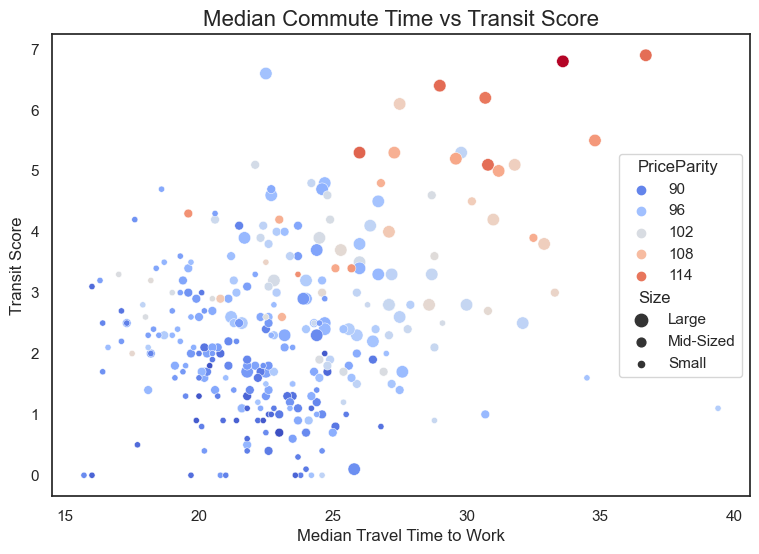

In [62]:
palette = sns.color_palette("coolwarm", as_cmap=True)
sns.scatterplot(data=cities, x='CommuteTime', y='TransitScore', hue='PriceParity', palette=palette, 
                size='Size', size_order=['Large', 'Mid-Sized', 'Small'], sizes=[80, 40, 20])
plt.title('Median Commute Time vs Transit Score', fontsize=16)
plt.xlabel('Median Travel Time to Work')
plt.ylabel('Transit Score')
plt.show()

The larger and more expensive cities occupy the upper right corner of the graph, while smaller and cheaper cities are associated with poorer public transportation and shorter commutes.

### Average Income and Rent by Size and Region

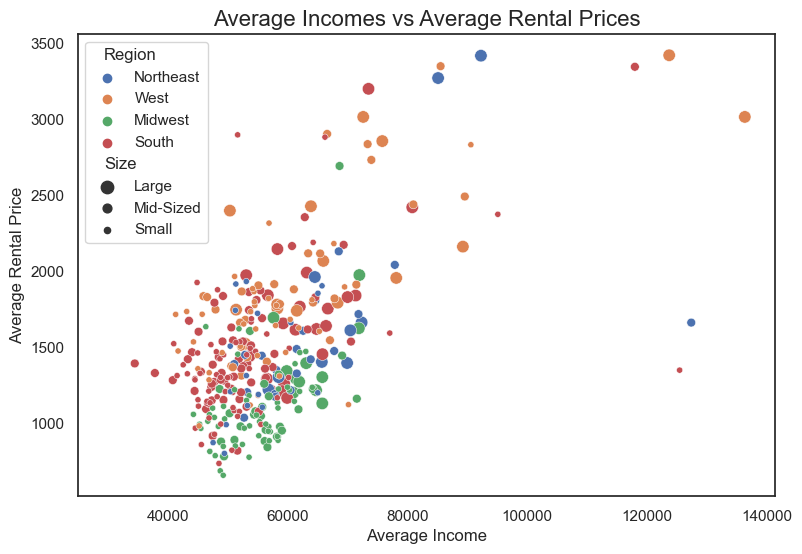

In [63]:
ax = sns.scatterplot(data=cities, x='AvgIncome', y='AvgRent', hue='Region', 
                size='Size', size_order=['Large', 'Mid-Sized', 'Small'], sizes=[80, 40, 20])
ax.set_xlim(left=25000)
plt.title('Average Incomes vs Average Rental Prices', fontsize=16)
plt.xlabel('Average Income')
plt.ylabel('Average Rental Price')
plt.show()

From the graph, we can see that the South has lower incomes than the Midwest (with a number of outliers), but more expensive rents. The western cities have higher rents, but also higher incomes. Let's run the Tukey's test to see if the average incomes and rental prices are significantly different between the US regions.
- A value of 0 indicates that there is no significant difference in average income between the corresponding regions.
- A value of 1 indicates that there is a significant difference in average income between the corresponding regions. 

In [64]:
# Differences in the means of average incomes
sp.posthoc_tukey_hsd(x=cities.AvgIncome, g=cities.Region)

,Midwest,Northeast,South,West
Midwest,1,1,0,0
Northeast,1,1,1,0
South,0,1,1,1
West,0,0,1,1


The table shows some interesting results. There's no significant difference in average incomes in the Midwest-South and Midwest-West pairs, but there is a difference in West-South. The Northeast and South incomes are the most "different" from the rest of the group. From the scatterplot, we can conclude that the Northeast has the highest, while the South has the lowest. The Western cities are second in terms of income, and the Midwest is third.

Let's check this assumption by looking at the actual means.

In [65]:
# Income means across regions
region_list = ['Midwest', 'Northeast', 'South', 'West']
for region in region_list:
    print(f"Average income in {region} is {cities[cities['Region'] == region]['AvgIncome'].mean()}")

Average income in Midwest is 56058.39759036145
Average income in Northeast is 62188.065217391304
Average income in South is 54122.794117647056
Average income in West is 60972.50632911392


In [66]:
# Differences in means of average rental prices
sp.posthoc_tukey_hsd(x=cities.AvgRent, g=cities.Region)

,Midwest,Northeast,South,West
Midwest,1,1,1,1
Northeast,1,1,0,1
South,1,0,1,1
West,1,1,1,1


In [67]:
for region in ['Midwest', 'Northeast', 'South', 'West']:
    print(f"Average rental in {region} is {cities[cities['Region'] == region]['AvgRent'].mean()}")

Average rental in Midwest is 1135.3975903614457
Average rental in Northeast is 1548.5652173913043
Average rental in South is 1476.2426470588234
Average rental in West is 1866.8354430379748


The only pair with no significant difference is Northeast-South. From these two tables and the scatterplot, we can see that a region with the highest rents is not the region with the highest incomes, and the region with the lowest rents is not the region with the lowest incomes. This could be explained by outliers in one of these two variables (for example, a city in the West with very high rents but moderate incomes).

### Median Rental Prices by Region and Size
Explore the rental prices by region further with regard to the size.

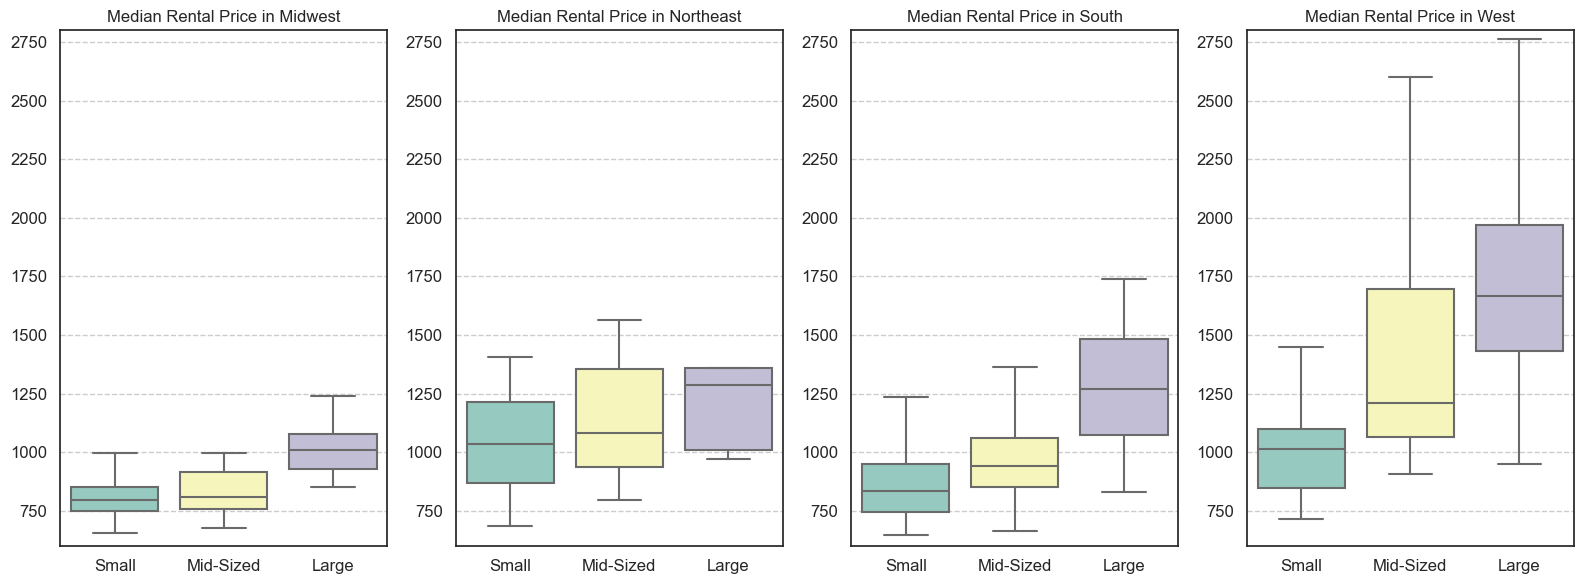

In [68]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

sns.set_palette("Set3")
ax1, ax2, ax3, ax4 = axes
ylim = (600, 2800)
fontsize = 12

for ax, region in zip(axes, region_list):
    sns.boxplot(y='MedianRent', x='Size', data=cities[cities['Region'] == region], ax=ax,
                showfliers=False, palette="Set3")
    
    ax.set_ylim(ylim)
    ax.set_title(f"Median Rental Price in {region}", fontsize=fontsize)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Adjust tick label font size and add grid lines
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.grid(True, linestyle='--', axis='y')

plt.tight_layout()
plt.show()

Large cities are more expensive to rent, but there are important differences between regions. For example, large cities in the Midwest are still cheaper than small cities in the Northeast. Midsize Western cities can be as expensive or more than large Southern and Northeastern cities.

### Unemployment Rate by Region and Size
Cities in the West have the highest unemployment rate, while the Northeast is the only region where small cities have a higher unemployment rate than medium-sized cities.

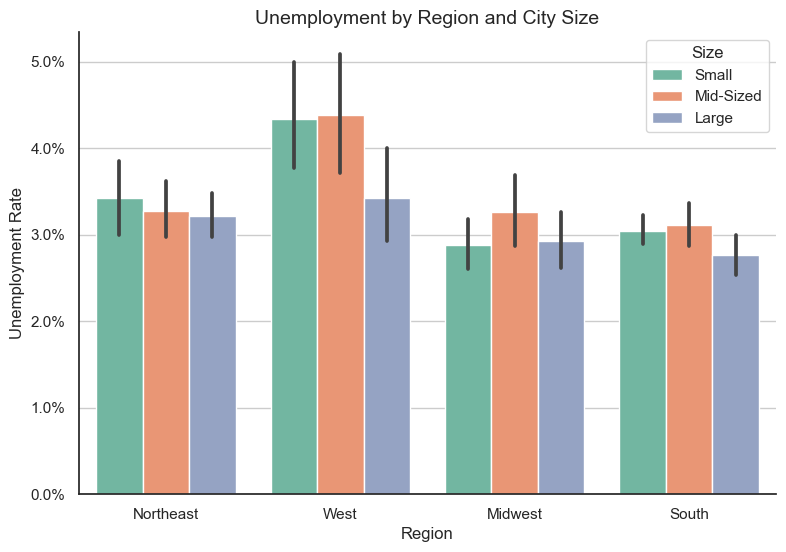

In [69]:
fig, ax = plt.subplots()
sns.set_palette("Set2")

with sns.axes_style("whitegrid"):
    sns.barplot(y='UnempRate', x='Region', hue='Size', data=cities)
    ax.set_ylabel('Unemployment Rate')

    # To show percetage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='-', axis='y')

plt.title('Unemployment by Region and City Size', fontsize=14)
plt.show()

### Commute Times by Region and Size
The bigger a city, the longer it takes to get to work. But there are some differences between regions.

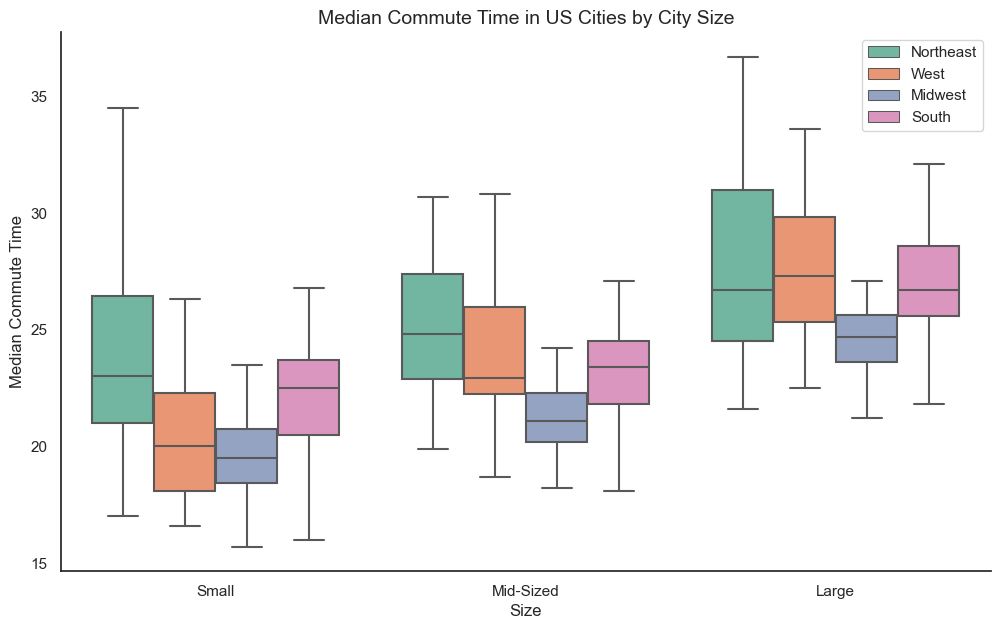

In [70]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.boxplot(y='CommuteTime', x='Size', hue='Region', data=cities, showfliers=False, ax=ax)

ax.set_ylabel('Median Commute Time')
ax.set_title('Median Commute Time in US Cities by City Size', fontsize=14)

ax.legend(loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Median AQI by Size

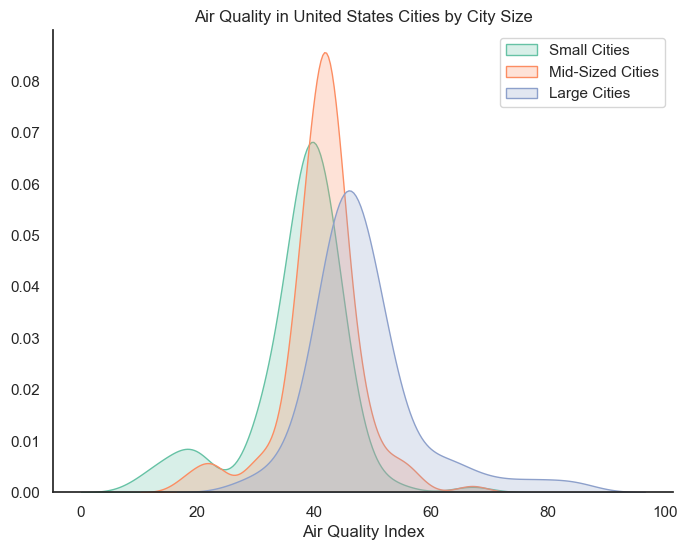

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_palette("Set1")

sns.kdeplot(data=small_cities['MedianAQI'], shade=True, label='Small Cities')
sns.kdeplot(data=mid_cities['MedianAQI'], shade=True, label='Mid-Sized Cities')
sns.kdeplot(data=large_cities['MedianAQI'], shade=True, label='Large Cities')

plt.xlabel('Air Quality Index')
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Air Quality in United States Cities by City Size')
plt.legend()

plt.show()

Obviously, the smaller the city, the cleaner the air. The index from 0 to 50 is considered good, from 51 to 100 – moderate. In the long run, there is no city with unhealthy air. Still, some large cities are in the upper half of what is considered moderate. No large city has an AQI below 20, which makes sense since "large cities" in the US are really large.

In [72]:
cities[cities['MedianAQI'] >= 75][['City', 'Population', 'MedianAQI']]

,City,Population,MedianAQI
10,Phoenix,4845832.0,77.0
12,Riverside,4599839.0,84.0


# Conclusion
<b>1.</b> By the end of this project, we have a dataset of American cities with a dozen variables. We gathered this data from open sources and explained how each variable was collected and calculated. We also assigned two categories (Region and Size) based on the data. 
At first, we did a lot of cleaning in Python to be able to merge the data with the final dataset (AvgRent, MedianRent, UnempRate columns). The latest data was much cleaner, and we pre-processed it in Excel to save time. I usually just separated the columns with a delimiter and formatted the numeric values.
Then we cleaned the data: found and replaced missing data, dropped raws with lots of missing values, and corrected data types.
This dataset can be found on this project's [GitHub](https://github.com/denislsad/us_cities) page. I have also uploaded it on [Kaggle](https://www.kaggle.com/datasets/denissad/us-cities).

<b>2.</b> After collecting and cleaning the data, I used exploratory data analysis. There are many ways to explore this data, and I chose to do the following:
- Map of cities by size with all variable information in the toolkit;
- Heatmap to see the correlation between all variables and summary statistics tables;
- Scatterplot of correlation between commute times and transit score (by size);
- Scatterplot of correlation between average incomes and rents (by size and region);
- Boxplot of median rental prices (by region and size);
- Bar chart of unemployment rates (by region and size);
- Box plot of commute times (by region and size);
- Distribution plot of median air quality index (by size).

<b>Findings.</b> Some of the things we found during the analysis:
- The median rental price can be a better predictor of a city's livability than the average rental price – because it has a stronger correlation with other variables;
- The data confirms all the chronic problems of metro areas with large populations: poor air quality, longer commutes, high cost of living. But they have better public transportation and are more pedestrian friendly;
- Rents in the South are not significantly lower than in the Northeast, but incomes are much lower. Conversely, the Midwest has the same incomes as the South, but rents are much lower.
- Despite lower incomes, cities in the Midwest and South have lower unemployment rates;
- The Midwest also has the shortest commute times of any size category.